In [1]:
import django
import os
import sys
import shutil

path='../../'

source_file_path = f'{path}.env'

destination_file_path = '.'

shutil.copy(source_file_path, destination_file_path)

from dotenv import dotenv_values

_config = dotenv_values(".env")
_username = _config["username"]

session_file_path = f'{path}{_username}.session'

# shutil.copy('Farnoooooood.session', destination_file_path)


project_path = path  # Adjust this to your actual project path
sys.path.append(project_path)
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'oogway.settings')
django.setup()


In [2]:
import warnings
from Channels.AliBeyroChannel import AliBeyroChannel
from Shared.Exchange import exchange
from Shared.helpers import convertDateToMilliTimeStamp, zero_hours_minutes_seconds
from Shared.dataIO import load_historic_tohlcv_json
from bisect import bisect_left

aliBey = AliBeyroChannel()


# Disable all warnings
warnings.filterwarnings("ignore")

In [7]:
from django.db.models import Sum
from django.db.models.functions import TruncMonth
from PostAnalyzer.models import Predict
from asgiref.sync import sync_to_async
# Django ORM equivalent
results = await sync_to_async(
        lambda: list(
            Predict.objects
            .select_related('post__channel')
            .annotate(month=TruncMonth('date'))
            .values('post__channel__name', 'month')
            .annotate(total_profit=Sum('profit'))
            .order_by('month', 'post__channel__name')
        )
    )()

for result in results:
    print(result['post__channel__name'], result['month'], result['total_profit'])

# results


FEYZIAN 2023-11-01 00:00:00+03:30 42.99123
FEYZIAN 2023-12-01 00:00:00+03:30 -343.2853999999999
FEYZIAN 2024-01-01 00:00:00+03:30 -113.16238999999999
FEYZIAN 2024-02-01 00:00:00+03:30 153.73805
FEYZIAN 2024-03-01 00:00:00+03:30 74.97560000000001
FEYZIAN 2024-04-01 00:00:00+03:30 77.9062
FEYZIAN 2024-05-01 00:00:00+03:30 -223.99226999999996
FEYZIAN 2024-06-01 00:00:00+03:30 -97.64638000000002
FEYZIAN 2024-07-01 00:00:00+03:30 -28.48347000000002
FEYZIAN 2024-08-01 00:00:00+03:30 -142.77534000000003
FEYZIAN 2024-09-01 00:00:00+03:30 -22.08712999999999
ALI_BEY 2024-10-01 00:00:00+03:30 614.78851
FEYZIAN 2024-10-01 00:00:00+03:30 -90.73062999999996
ALI_BEY 2024-11-01 00:00:00+03:30 -310.1128
FEYZIAN 2024-11-01 00:00:00+03:30 -39.51228


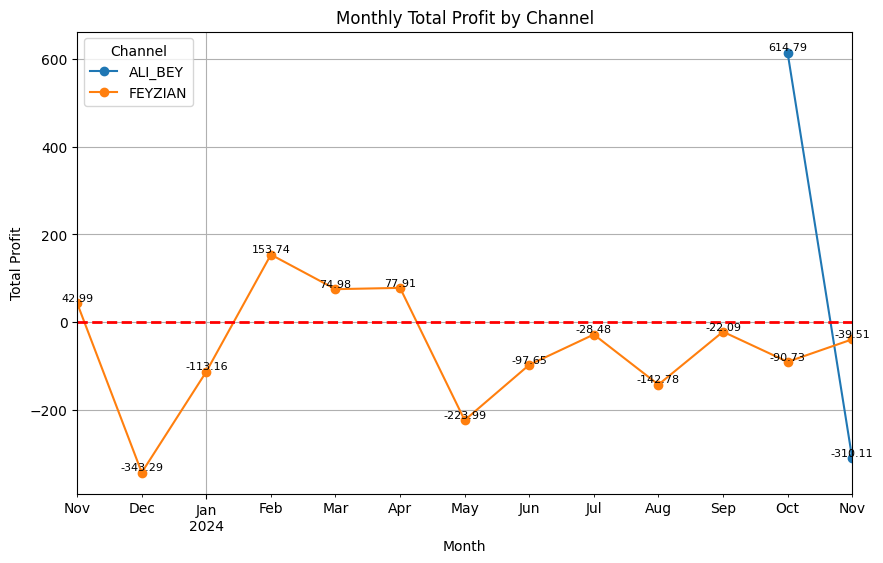

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Sample data to simulate results from Django ORM
# Assuming `results` has the fields `channel_name`, `month`, and `total_profit`


# Convert the data to a DataFrame
df = pd.DataFrame(results)

# Pivot the DataFrame to format it for plotting
pivot_df = df.pivot(index='month', columns='post__channel__name', values='total_profit')

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
pivot_df.plot(kind='line', marker='o', ax=ax)

# Adding a high contrast horizontal line at y=0
ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
# ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Baseline (y=0)')

# Setting labels, title, and legend
plt.title('Monthly Total Profit by Channel')
plt.xlabel('Month')
plt.ylabel('Total Profit')
plt.legend(title='Channel')
plt.grid()
for channel in pivot_df.columns:
    for month, value in pivot_df[channel].items():
        if pd.notnull(value):  # Only annotate non-null values
            ax.text(month, value, f'{value:.2f}', ha='center', va='bottom', fontsize=8)

plt.show()




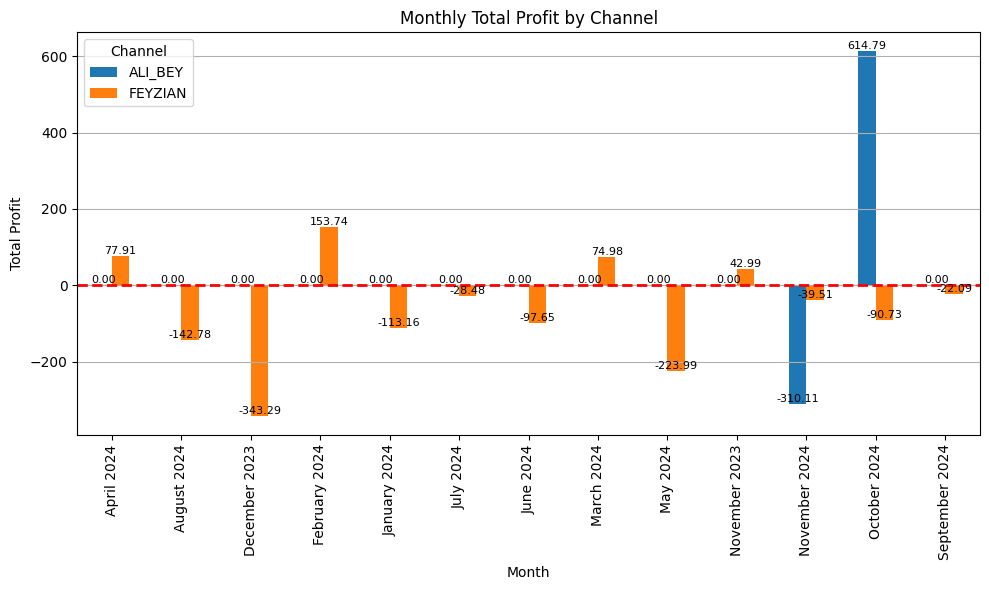

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Sample data to simulate results from Django ORM
# Assuming `results` has the fields `channel_name`, `month`, and `total_profit`


# Convert the data to a DataFrame
df = pd.DataFrame(results)
df['month'] = pd.to_datetime(df['month']).dt.strftime('%B %Y')
# Pivot the DataFrame to format it for plotting
pivot_df = df.pivot(index='month', columns='post__channel__name', values='total_profit')

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
pivot_df.plot(kind='bar', ax=ax)

# Adding a high contrast horizontal line at y=0
ax.axhline(y=0, color='red', linestyle='--', linewidth=2)

# Setting labels, title, and legend
plt.title('Monthly Total Profit by Channel')
plt.xlabel('Month')
plt.ylabel('Total Profit')
plt.legend(title='Channel')
plt.grid(axis='y')  # Grid only for y-axis to improve readability

# Adding data labels to each bar
for p in ax.patches:
    height = p.get_height()
    if pd.notnull(height):  # Only annotate non-null values
        ax.text(
            p.get_x() + p.get_width() / 2,
            height,
            f'{height:.2f}',
            ha='center',
            va='bottom',
            fontsize=8
        )

plt.tight_layout()
plt.show()


In [45]:
from django.db.models import Sum, Count
from PostAnalyzer.models import Predict
from asgiref.sync import sync_to_async

# Define an async function
gross_loss = await sync_to_async(
    lambda: Predict.objects.filter(
        status__name__in=['FAILED WITH PROFIT', 'FAILED']
    ).aggregate(
        failed_profit=Sum('profit'),
        failed_count=Count('id')
    )
)()

gross_loss


{'failed_profit': -5242.393559999999, 'failed_count': 224}

In [44]:
from django.db.models import Sum, Count
from PostAnalyzer.models import Predict
from asgiref.sync import sync_to_async

# Define an async function
gross_win = await sync_to_async(
    lambda: Predict.objects.filter(
        status__name__in=['SUCCESS', 'FULLTARGET']
    ).aggregate(
        win_profit=Sum('profit'),
        win_count=Count('id')
    )
)()

gross_win


{'win_profit': 4795.0050599999995, 'win_count': 109}

In [70]:
from django.db.models import Sum, Count, Case, When, IntegerField, FloatField
from PostAnalyzer.models import Predict
from asgiref.sync import sync_to_async

# Define an async function
result = await sync_to_async(
    lambda: Predict.objects.filter(**{}).aggregate(
        gross_loss=Sum(
            Case(
                When(status__name__in=['FAILED WITH PROFIT', 'FAILED'], then='profit'),
                output_field=FloatField()
            )
        ),
        loss_count=Count(
            Case(
                When(status__name__in=['FAILED WITH PROFIT', 'FAILED'], then=1),
                output_field=IntegerField()
            )
        ),
        gross_profit=Sum(
            Case(
                When(status__name__in=['SUCCESS', 'FULLTARGET'], then='profit'),
                output_field=FloatField()
            )
        ),
        win_count=Count(
            Case(
                When(status__name__in=['SUCCESS', 'FULLTARGET'], then=1),
                output_field=IntegerField()
            )
        ),
        total_gross=Sum('profit', output_field=FloatField()),  # Total profit for all statuses
        total_count=Count('id', output_field=IntegerField()) 
    )
)()

gross_loss = result['gross_loss']
loss_count = result['loss_count']
gross_profit = result['gross_profit']
win_count = result['win_count']
total_count = result['total_count']
total_gross = result['total_gross']

loss_rate = loss_count/total_count
win_rate = win_count/total_count
average_loss = gross_loss/loss_count
average_win = gross_profit/win_count
expectancy = (win_rate * average_win)-(abs(loss_rate * average_loss))
profit_factor =  abs(gross_profit/gross_loss if gross_loss else 1)
payoff_ratio = abs(average_win/average_loss if average_loss else 1)

print(f'total_count: {total_count}')
print(f'total_gross: {total_gross}')
print(f'total_count: {total_count}')
print(f'gross_loss: {gross_loss}')
print(f'loss_count: {loss_count}')
print(f'gross_profit: {gross_profit}')
print(f'win_count: {win_count}')
print(f'loss_rate: {loss_rate}')
print(f'win_rate: {win_rate}')
print(f'average_loss: {average_loss}')
print(f'average_win: {average_win}')
print(f'expectancy: {expectancy}')
print(f'profit_factor: {profit_factor}')
print(f'payoff_ratio: {payoff_ratio}')


total_count: 420
total_gross: -447.38850000000025
total_count: 420
gross_loss: -5242.393559999999
loss_count: 224
gross_profit: 4795.0050599999995
win_count: 109
loss_rate: 0.5333333333333333
win_rate: 0.25952380952380955
average_loss: -23.403542678571423
average_win: 43.990872110091736
expectancy: -1.065210714285712
profit_factor: 0.9146594976360379
payoff_ratio: 1.8796672244997477


In [149]:
from django.db.models import Sum, Count
from PostAnalyzer.models import Predict
from asgiref.sync import sync_to_async

# Define an async function to get sum and count of profits for each status
result = await sync_to_async(
    lambda: list(
        Predict.objects.values('status__name')
        .annotate(
            total_profit=Sum('profit'),
            profit_count=Count('id')
        )
        .order_by('status__name')
    )
)()

result


[{'status__name': 'CANCELED', 'total_profit': 0.0, 'profit_count': 48},
 {'status__name': 'FAILED',
  'total_profit': -1958.0420900000001,
  'profit_count': 86},
 {'status__name': 'FAILED WITH PROFIT',
  'total_profit': -3284.3514700000005,
  'profit_count': 138},
 {'status__name': 'FULLTARGET',
  'total_profit': 3269.79068,
  'profit_count': 83},
 {'status__name': 'PENDING', 'total_profit': 0.0, 'profit_count': 12},
 {'status__name': 'SUCCESS',
  'total_profit': 1525.2143800000001,
  'profit_count': 26},
 {'status__name': 'WAIT MANY DAYS', 'total_profit': 0.0, 'profit_count': 27}]

In [147]:
from asgiref.sync import sync_to_async
from PostAnalyzer.models import TakeProfitTarget
from django.db.models import Count, Max

async def get_tp_num_counts():
    # Step 1: Perform the inner query, grouping by predict_id, counting entries, and getting max profit
    subquery = await sync_to_async(
        lambda: list(
            TakeProfitTarget.objects.filter(active=True)
            .values('predict_id')
            .annotate(
                tp_index=Count('id'),            
                max_profit=Max('profit')        
            )
        )
    )()

    
    tp_result = {}
    for entry in subquery:
        tp_index = entry['tp_index']
        max_profit = entry['max_profit']
        if tp_index not in tp_result:
            tp_result[tp_index] = {'count': 0, 'total_profit': 0}
        tp_result[tp_index]['count'] += 1
        tp_result[tp_index]['total_profit'] += max_profit

    
    result = [
        {'tp_index': tp_index, 'count': data['count'], 'total_profit': data['total_profit']}
        for tp_index, data in sorted(tp_result.items())
    ]
    
    return result

await get_tp_num_counts()


[{'tp_index': 1, 'count': 56, 'total_profit': 402.42161999999996},
 {'tp_index': 2, 'count': 34, 'total_profit': 533.4348200000001},
 {'tp_index': 3, 'count': 35, 'total_profit': 770.7153700000001},
 {'tp_index': 4, 'count': 46, 'total_profit': 1696.93401},
 {'tp_index': 5, 'count': 57, 'total_profit': 2279.2423000000003},
 {'tp_index': 6, 'count': 12, 'total_profit': 779.6194199999999},
 {'tp_index': 7, 'count': 4, 'total_profit': 303.29456},
 {'tp_index': 8, 'count': 1, 'total_profit': 78.59532},
 {'tp_index': 9, 'count': 1, 'total_profit': 145.16129},
 {'tp_index': 10, 'count': 1, 'total_profit': 161.65414}]

## Get channel history

In [3]:

# اول فروردین = 2024/3/20
# end_date = datetime(2024, 3, 20, tzinfo=timezone.utc)
# اول خرداد = 2024/5/21
# end_date = datetime(2024, 5, 21, tzinfo=timezone.utc)
# start_date = datetime(2024, 5, 29, tzinfo=timezone.utc)
# اول تیر = 2024/6/21
# start_date = datetime(2024, 6, 21, tzinfo=timezone.utc)
# end_date = datetime(2024, 9, 7, tzinfo=timezone.utc)


# 1709889120000 1709975340000
# offset_date = int(convertDateToMilliTimeStamp(year=2024, month=4, day=30, hour=0, minute=0))/1000

await aliBey.FindStatistic(year=2024, month=10, day=5, 
                        # offset_date=offset_date
                        )
    

Current Offset ID is: 0 ; Total Messages: 0


100%|██████████| 100/100 [00:00<?, ?it/s]


Current Offset ID is: 6671 ; Total Messages: 100


100%|██████████| 100/100 [00:00<?, ?it/s]


Current Offset ID is: 6568 ; Total Messages: 200


100%|██████████| 100/100 [00:00<?, ?it/s]


Current Offset ID is: 6466 ; Total Messages: 300


100%|██████████| 100/100 [00:00<?, ?it/s]


Current Offset ID is: 6366 ; Total Messages: 400


 37%|███▋      | 37/100 [00:00<00:00, 265280.77it/s]


OP/USDT:USDT SHORT
{'tps': [[1729879800000, 1.6352, 1.6358, 1.63, 1.6344, 18969.3], [1729898040000, 1.5832, 1.5848, 1.5681, 1.57, 23262.6], [1729898580000, 1.526, 1.5289, 1.4908, 1.5027, 199432.6], [1730560200000, 1.4447, 1.4449, 1.4386, 1.4395, 55595.4], [1730643900000, 1.366, 1.3678, 1.3587, 1.3605, 20461.1], [1730753460000, 1.3218, 1.3218, 1.3199, 1.3212, 345.2]], 'entry_reached': [[1729758720000, 1.6996, 1.7006, 1.6994, 1.6997, 423.1]], 'stop_loss_reached': None, 'break_reason': None}


TRX/USDT:USDT SHORT


{'tps': [[1729897500000, 0.16442, 0.16442, 0.16384, 0.16391, 167155.0]], 'entry_reached': [[1729855860000, 0.16606, 0.1661, 0.16606, 0.16608, 119081.0]], 'stop_loss_reached': None, 'break_reason': None}


BNB/USDT:USDT SHORT
{'tps': [[1730640900000, 555.13, 555.57, 554.85, 555.56, 60.49]], 'entry_reached': [[1729917240000, 578.66, 578.66, 578.48, 578.62, 19.36]], 'stop_loss_reached': None, 'break_reason': None}


INJ/USDT:USDT SHORT
{'tps': [[1729950660000, 18.331, 18.335, 18.293, 18.309, 2222.0], [1729954740000, 18.026, 18.027, 17.978, 18.002, 2775.0], [1730599620000, 17.71, 17.71, 17.694, 17.695, 2067.0], [1730601720000, 17.375, 17.392, 17.294, 17.298, 1978.0], [1730641680000, 17.031, 17.031, 16.949, 16.959, 4040.0]], 'entry_reached': [[1729917720000, 18.52, 18.577, 18.52, 18.574, 1898.0]], 'stop_loss_reached': None, 'break_reason': None}


OP/USDT:USDT SHORT
{'tps': [[1730496840000, 1.5145, 1.5145, 1.5092, 1.5101, 13308.5], [1730560200000, 1.4447, 1.4449, 1.4386, 1.4395, 55595.4], [1730643900000, 1.366, 1.3678, 1.3587, 1.3605, 20461.1], [1730753460000, 1.3218, 1.3218, 1.3199, 1.3212, 345.2]], 'entry_reached': [[1729974120000, 1.5791, 1.5804, 1.5791, 1.5802, 6955.8]], 'stop_loss_reached': None, 'break_reason': None}


APT/USDT:USDT SHORT


{'tps': [[1730086320000, 8.8706, 8.871, 8.8237, 8.8237, 5816.1], [1730088000000, 8.7217, 8.7225, 8.6999, 8.71, 22840.4], [1730551800000, 8.5698, 8.5925, 8.56, 8.5907, 3981.7], [1730601060000, 8.3464, 8.3644, 8.32, 8.3246, 43481.9], [1730603040000, 8.1193, 8.1216, 8.0828, 8.089, 8370.3], [1730641860000, 7.9754, 7.9797, 7.94, 7.945, 7533.3]], 'entry_reached': [[1730012460000, 9.1256, 9.1527, 9.1254, 9.1517, 3974.3], [1730207940000, 10.1105, 10.1222, 10.1022, 10.1205, 8870.2]], 'stop_loss_reached': None, 'break_reason': None}


DOGE/USDT:USDT SHORT


{'tps': [], 'entry_reached': [[1730057400000, 0.14118, 0.14159, 0.14115, 0.14159, 636021.0], [1730139300000, 0.15265, 0.15303, 0.15253, 0.1527, 936077.0]], 'stop_loss_reached': [1730143260000, 0.15773, 0.1579, 0.15746, 0.15748, 11648622.0], 'break_reason': None}


AAVE/USDT:USDT SHORT


{'tps': [[1730398080000, 143.61, 143.62, 143.38, 143.47, 221.6], [1730402220000, 141.41, 141.59, 141.28, 141.34, 205.9], [1730554560000, 139.06, 139.14, 138.7, 139.13, 290.5], [1730601000000, 136.11, 136.13, 135.47, 135.6, 426.8], [1730640720000, 133.45, 133.45, 132.9, 133.08, 267.4], [1730659260000, 129.22, 129.23, 128.66, 128.71, 606.9], [1730757120000, 126.24, 126.26, 125.89, 126.13, 215.7]], 'entry_reached': [[1730063940000, 144.68, 144.72, 144.68, 144.69, 194.2], [1730118840000, 153.61, 153.91, 153.51, 153.6, 989.3]], 'stop_loss_reached': [1730901720000, 162.36, 164.16, 162.33, 164.0, 506.7], 'break_reason': None}


APT/USDT:USDT SHORT
{'tps': [[1730443980000, 8.869, 8.872, 8.8586, 8.8618, 1497.1], [1730476260000, 8.7228, 8.7234, 8.6715, 8.7014, 10144.8], [1730551800000, 8.5698, 8.5925, 8.56, 8.5907, 3981.7], [1730601060000, 8.3464, 8.3644, 8.32, 8.3246, 43481.9], [1730603040000, 8.1193, 8.1216, 8.0828, 8.089, 8370.3], [1730641860000, 7.9754, 7.9797, 7.94, 7.945, 7533.3]], 'entry_reached': [[1730151780000, 9.1535, 9.1756, 9.1513, 9.1756, 4390.8], [1730251200000, 10.1305, 10.2124, 10.1261, 10.2075, 7804.9]], 'stop_loss_reached': None, 'break_reason': None}


DOGE/USDT:USDT SHORT


{'tps': [[1730404200000, 0.16224, 0.16224, 0.16089, 0.16098, 892598.0], [1730407620000, 0.15814, 0.15829, 0.15799, 0.15804, 4422419.0], [1730600580000, 0.15485, 0.15485, 0.15375, 0.15406, 5527548.0], [1730601420000, 0.1514, 0.15141, 0.15094, 0.15107, 2993846.0], [1730640780000, 0.14767, 0.14775, 0.14697, 0.14719, 3384002.0], [1730648280000, 0.143, 0.143, 0.14254, 0.14292, 3876759.0]], 'entry_reached': [[1730193240000, 0.1649, 0.16515, 0.16483, 0.16513, 197957.0], [1730218920000, 0.17669, 0.17918, 0.17669, 0.17911, 3367731.0]], 'stop_loss_reached': [1730860080000, 0.18654, 0.1879, 0.18652, 0.18788, 6712604.0], 'break_reason': None}


WIF/USDT:USDT SHORT


{'tps': [], 'entry_reached': [], 'stop_loss_reached': None, 'break_reason': None}


AAVE/USDT:USDT SHORT


{'tps': [[1730383440000, 147.23, 147.24, 146.16, 146.39, 419.2], [1730398080000, 143.61, 143.62, 143.38, 143.47, 221.6], [1730402220000, 141.41, 141.59, 141.28, 141.34, 205.9], [1730554560000, 139.06, 139.14, 138.7, 139.13, 290.5], [1730601000000, 136.11, 136.13, 135.47, 135.6, 426.8], [1730640720000, 133.45, 133.45, 132.9, 133.08, 267.4], [1730659260000, 129.22, 129.23, 128.66, 128.71, 606.9], [1730757120000, 126.24, 126.26, 125.89, 126.13, 215.7]], 'entry_reached': [[1730362080000, 152.3, 152.33, 152.28, 152.3, 186.0]], 'stop_loss_reached': [1730901720000, 162.36, 164.16, 162.33, 164.0, 506.7], 'break_reason': None}


BNB/USDT:USDT SHORT


{'tps': [[1730640900000, 555.13, 555.57, 554.85, 555.56, 60.49]], 'entry_reached': [[1730362920000, 584.63, 584.63, 584.16, 584.19, 175.55]], 'stop_loss_reached': None, 'break_reason': None}


BNB/USDT:USDT SHORT


{'tps': [[1730640900000, 555.13, 555.57, 554.85, 555.56, 60.49]], 'entry_reached': [[1730362980000, 584.17, 584.19, 583.86, 583.86, 107.12]], 'stop_loss_reached': None, 'break_reason': None}


TRX/USDT:USDT SHORT


{'tps': [[1730599860000, 0.16517, 0.16519, 0.16461, 0.1648, 196334.0], [1730828760000, 0.16124, 0.16124, 0.16081, 0.16091, 306271.0]], 'entry_reached': [[1730364540000, 0.16946, 0.16951, 0.16946, 0.16948, 207330.0]], 'stop_loss_reached': None, 'break_reason': None}


DOGE/USDT:USDT SHORT


{'tps': [[1730383440000, 0.16532, 0.16534, 0.1648, 0.16503, 2704182.0], [1730398740000, 0.16207, 0.16212, 0.1616, 0.16165, 1792670.0], [1730407620000, 0.15814, 0.15829, 0.15799, 0.15804, 4422419.0], [1730600580000, 0.15485, 0.15485, 0.15375, 0.15406, 5527548.0], [1730601420000, 0.1514, 0.15141, 0.15094, 0.15107, 2993846.0], [1730640780000, 0.14767, 0.14775, 0.14697, 0.14719, 3384002.0], [1730648280000, 0.143, 0.143, 0.14254, 0.14292, 3876759.0]], 'entry_reached': [[1730366880000, 0.17084, 0.1713, 0.17083, 0.1713, 3313498.0]], 'stop_loss_reached': [1730860080000, 0.18654, 0.1879, 0.18652, 0.18788, 6712604.0], 'break_reason': None}


ADA/USDT:USDT SHORT


{'tps': [[1730603040000, 0.33528, 0.33562, 0.33481, 0.33522, 186056.0], [1730738580000, 0.32401, 0.32427, 0.32389, 0.32409, 193057.0]], 'entry_reached': [[1730464320000, 0.3493, 0.35014, 0.34909, 0.34993, 83162.0]], 'stop_loss_reached': None, 'break_reason': None}


OP/USDT:USDT SHORT


{'tps': [], 'entry_reached': [], 'stop_loss_reached': None, 'break_reason': None}


DOGE/USDT:USDT SHORT


{'tps': [[1730770140000, 0.16198, 0.162, 0.1608, 0.16101, 939024.0]], 'entry_reached': [[1730767740000, 0.16529, 0.1664, 0.16518, 0.16616, 7977262.0], [1730818200000, 0.1776, 0.179, 0.17759, 0.17884, 2680522.0]], 'stop_loss_reached': [1730860200000, 0.18863, 0.1898, 0.18826, 0.18902, 8948335.0], 'break_reason': None}


SUI/USDT:USDT SHORT


{'tps': [[1730570940000, 1.88339, 1.884, 1.87888, 1.87891, 84174.0], [1730601720000, 1.83702, 1.83774, 1.82806, 1.82806, 442805.0], [1730646240000, 1.78581, 1.78602, 1.77962, 1.78186, 84720.0]], 'entry_reached': [[1730540400000, 1.93759, 1.94357, 1.93759, 1.94332, 21475.0], [1730873100000, 2.34773, 2.354, 2.32498, 2.32692, 149669.0]], 'stop_loss_reached': None, 'break_reason': None}


DOGE/USDT:USDT SHORT


{'tps': [[1730732040000, 0.15551, 0.15551, 0.15444, 0.15458, 3996236.0]], 'entry_reached': [[1730725860000, 0.15812, 0.15884, 0.15801, 0.15879, 951518.0], [1730789700000, 0.16839, 0.16914, 0.16836, 0.16882, 3981921.0]], 'stop_loss_reached': [1730818200000, 0.1776, 0.179, 0.17759, 0.17884, 2680522.0], 'break_reason': None}


SUI/USDT:USDT SHORT


{'tps': [[1730757120000, 1.80099, 1.80142, 1.79274, 1.79731, 95667.0]], 'entry_reached': [[1730750160000, 1.84708, 1.84999, 1.84701, 1.84896, 11194.0], [1730862300000, 2.24791, 2.25634, 2.2402, 2.24841, 323132.0]], 'stop_loss_reached': [1730871000000, 2.32318, 2.33441, 2.30356, 2.30492, 164062.0], 'break_reason': None}


DOGE/USDT:USDT SHORT


{'tps': [], 'entry_reached': [[1730784960000, 0.16334, 0.16349, 0.16331, 0.16343, 1163862.0], [1730818200000, 0.1776, 0.179, 0.17759, 0.17884, 2680522.0]], 'stop_loss_reached': [1730860200000, 0.18863, 0.1898, 0.18826, 0.18902, 8948335.0], 'break_reason': None}


BNB/USDT:USDT SHORT


{'tps': [], 'entry_reached': [[1730792640000, 559.87, 560.0, 559.85, 560.0, 19.33]], 'stop_loss_reached': None, 'break_reason': None}


SHIB/USDT:USDT SHORT


{'tps': [], 'entry_reached': [], 'stop_loss_reached': None, 'break_reason': None}


RUNE/USDT:USDT SHORT


{'tps': [], 'entry_reached': [[1730853060000, 4.753, 4.789, 4.751, 4.785, 2132.0], [1730874360000, 5.395, 5.45, 5.391, 5.443, 4150.0]], 'stop_loss_reached': None, 'break_reason': None}


RUNE/USDT:USDT SHORT


{'tps': [], 'entry_reached': [[1730872980000, 5.28, 5.29, 5.279, 5.28, 3880.0]], 'stop_loss_reached': None, 'break_reason': None}


True